In [1]:
import os
import glob
import torch
import numpy as np
import scanpy as sc
import anndata as ad
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from gridnext.gridnet_models import GridNetHexOddr
from gridnext.visium_datasets import create_visium_dataset, create_visium_anndata
from gridnext.count_datasets import anndata_to_tensordataset, anndata_arrays_to_tensordataset
from gridnext.training import train_spotwise, train_gridwise
from gridnext.utils import all_fgd_predictions, to_loupe_annots, visium_find_position_file
from gridnext.plotting import performance_curves

In [2]:
# Download data from: https://zenodo.org/uploads/10372917

data_dir = '../data/BA44_testdata'

In [3]:
spaceranger_dirs = sorted(glob.glob(os.path.join(data_dir, 'spaceranger', '*')))
annot_files = sorted(glob.glob(os.path.join(data_dir, 'annotations', '*.csv')))

## 1.1 Load spot data

### a) Load large dataset (low memory usage, slow accession)
Map-style PyTorch dataset for lazy loading of spots from large datasets. Use when full data cannot fit into memory.

In [4]:
# First, create a CountDataset using all arrays to generate unified countfiles:
# (once this has been done once, you can skip straight to train/test set creation)
pdat = create_visium_dataset(spaceranger_dirs, annot_files=annot_files, 
                             use_count=True, use_image=False, spatial=False)

# Create training and validation datasets
n_val = 1
train_srd = spaceranger_dirs[n_val:]
train_ann = annot_files[n_val:]

val_srd = spaceranger_dirs[:n_val]
val_ann = annot_files[:n_val]

train_pdat = create_visium_dataset(train_srd, annot_files=train_ann,
                                   use_count=True, use_image=False, spatial=False)
val_pdat = create_visium_dataset(val_srd, annot_files=val_ann,
                                 use_count=True, use_image=False, spatial=False)
print('%d training and %d validation spots' % (len(train_pdat), len(val_pdat)))

assert np.array_equal(train_pdat.classes, val_pdat.classes), "Classes in train/val data do not match!"
class_names = train_pdat.classes
print('%d classes' % len(class_names))

1920 un-annotated spots
228 un-annotated spots
1692 un-annotated spots
19540 training and 2548 validation spots
7 classes


### b) Load small dataset (high memory usage, fast accession)
Load full dataset into memory for fast accession

In [5]:
# Create AnnData representation of full Visium data (all arrays)
destfile = os.path.join(data_dir, 'adata_tutorial.h5ad')

#adata = create_visium_anndata(spaceranger_dirs, annot_files=annot_files, destfile=destfile)
# Use for future accession after running previous line once:
adata = ad.read_h5ad(destfile)  # add "backed='r'" to avoid reading full AnnData into memory

In [6]:
# Perform desired preprocessing (normalization, log-transform, HVG selection, etc...)
sc.pp.normalize_total(adata, 1e4)
sc.pp.log1p(adata)

n_hvgs = 2000
cvar = np.abs(adata.X.std(axis=0) / adata.X.mean(axis=0))
cvar[adata.X.mean(axis=0) == 0] = 0  # disregard genes with 0 mean as HVGs
thresh_val = np.sort(cvar)[-n_hvgs]
adata = adata[:, cvar >= thresh_val]

/tmp/ipykernel_30042/2943881343.py:6: RuntimeWarning: invalid value encountered in divide
  cvar = np.abs(adata.X.std(axis=0) / adata.X.mean(axis=0))


In [7]:
# Create training and validation datasets
n_val = 1
val_arrays = adata.obs.array.unique()[:n_val]
train_arrays = adata.obs.array.unique()[n_val:]
adata_val = adata[adata.obs.array.isin(val_arrays)]
adata_train = adata[adata.obs.array.isin(train_arrays)]

train_pdat, train_classes  = anndata_to_tensordataset(adata_train, 'annotation')
val_pdat, val_classes = anndata_to_tensordataset(adata_val, 'annotation')
print('%d training and %d validation spots' % (len(train_pdat), len(val_pdat)))

assert np.array_equal(train_classes, val_classes), "Classes in train/val data do not match!"
class_names = train_classes
print('%d classes' % len(class_names))

19540 training and 2548 validation spots
7 classes


## 1.2. Train spot classifier

In [8]:
# Create data loaders for training loop
dataloader_spots = {
    'train': DataLoader(train_pdat, batch_size=128, shuffle=True),
    'val': DataLoader(val_pdat, batch_size=128)
}

In [9]:
# Instantiate fully-connected network to be used as spot classifier (f)
x, _ = train_pdat[0]
input_size = x.shape[0]

f = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.Linear(500, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),

    nn.Linear(100, 100),
    nn.Linear(100, 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),

    nn.Linear(50, len(class_names))
)

In [10]:
# Perform model training and save parameters
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(f.parameters(), lr=1e-4)

output_dir = '../models'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
outfile = os.path.join(output_dir, 'tutorial_f_count.pth')

f, f_val_hist, f_train_hist = train_spotwise(f, dataloader_spots, loss, optimizer, 
                                             num_epochs=10, display=False, outfile=outfile)

Epoch 0/9
----------
train Loss: 1.8952 Acc: 0.2193
val Loss: 1.9405 Acc: 0.1523

Epoch 1/9
----------
train Loss: 1.6938 Acc: 0.2819
val Loss: 1.9494 Acc: 0.1016

Epoch 2/9
----------
train Loss: 1.5845 Acc: 0.3139
val Loss: 1.9865 Acc: 0.1024

Epoch 3/9
----------
train Loss: 1.5157 Acc: 0.3621
val Loss: 2.0404 Acc: 0.3305

Epoch 4/9
----------
train Loss: 1.4676 Acc: 0.3903
val Loss: 2.0731 Acc: 0.3308

Epoch 5/9
----------
train Loss: 1.4386 Acc: 0.3950
val Loss: 2.1339 Acc: 0.3297

Epoch 6/9
----------
train Loss: 1.4170 Acc: 0.3959
val Loss: 2.1778 Acc: 0.3305

Epoch 7/9
----------
train Loss: 1.4005 Acc: 0.3973
val Loss: 2.2060 Acc: 0.3293

Epoch 8/9
----------
train Loss: 1.3886 Acc: 0.3973
val Loss: 2.2564 Acc: 0.3312

Epoch 9/9
----------
train Loss: 1.3792 Acc: 0.3992
val Loss: 2.2839 Acc: 0.3316

Training complete in 0m 11s
Best val loss: 1.940471


## 2.1. Load grid data

### a) Large dataset

In [11]:
# Create training and validation datasets
train_gdat = create_visium_dataset(train_srd, annot_files=train_ann,
                                   use_count=True, use_image=False, spatial=True)
val_gdat = create_visium_dataset(val_srd, annot_files=val_ann,
                                 use_count=True, use_image=False, spatial=True)
print('%d training and %d validation arrays' % (len(train_gdat), len(val_gdat)))

class_names = train_gdat.classes
print('%d classes' % len(class_names))

5 training and 1 validation arrays
7 classes


### b) Small dataset

In [12]:
train_gdat, train_classes = anndata_arrays_to_tensordataset(adata_train, 'annotation', 'array')
val_gdat, val_classes = anndata_arrays_to_tensordataset(adata_val, 'annotation', 'array')
print('%d training and %d validation grids' % (len(train_pdat), len(val_pdat)))

assert np.array_equal(train_classes, val_classes), "Classes in train/val data do not match!"
class_names = train_classes
print('%d classes' % len(class_names))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]

19540 training and 2548 validation grids
7 classes


## 2.2. Training spatial corrector network

In [13]:
# Create data loaders for training loop
dataloader_grids = {
    'train': DataLoader(train_gdat, batch_size=1, shuffle=True),
    'val': DataLoader(val_gdat, batch_size=1)
}

In [14]:
# Instantiate g network
H_VISIUM = 78
W_VISIUM = 64

g = GridNetHexOddr(f, (input_size,), (H_VISIUM, W_VISIUM), n_classes=len(class_names), use_bn=True)

In [15]:
# Train g network
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(g.corrector.parameters(), lr=1e-3)

# Fixing the parameters of the patch classifier allows slightly faster training, even when only
# optimizing the parameters of the corrector. 
for param in g.patch_classifier.parameters():
    param.requires_grad = False

outfile = os.path.join(output_dir, 'tutorial_g_count')

g, g_val_hist, g_train_hist = train_gridwise(g, dataloader_grids, loss, optimizer, 
                                             num_epochs=10, outfile=outfile)

Epoch 0/9
----------
train Loss: 2.3443 Acc: 0.1943
val Loss: 5.1600 Acc: 0.2916

Epoch 1/9
----------
train Loss: 1.7714 Acc: 0.3688
val Loss: 4.7319 Acc: 0.2967

Epoch 2/9
----------
train Loss: 1.4308 Acc: 0.4867
val Loss: 4.1587 Acc: 0.2673

Epoch 3/9
----------
train Loss: 1.2017 Acc: 0.5757
val Loss: 3.8149 Acc: 0.2253

Epoch 4/9
----------
train Loss: 1.0414 Acc: 0.6426
val Loss: 3.4962 Acc: 0.2347

Epoch 5/9
----------
train Loss: 0.9369 Acc: 0.6792
val Loss: 3.4014 Acc: 0.2092

Epoch 6/9
----------
train Loss: 0.8565 Acc: 0.7037
val Loss: 3.3055 Acc: 0.2060

Epoch 7/9
----------
train Loss: 0.7958 Acc: 0.7238
val Loss: 3.3374 Acc: 0.1739

Epoch 8/9
----------
train Loss: 0.7471 Acc: 0.7407
val Loss: 3.2900 Acc: 0.1597

Epoch 9/9
----------
train Loss: 0.7100 Acc: 0.7532
val Loss: 3.1558 Acc: 0.1684

Training complete in 0m 3s
Best val loss: 3.155843


## 3. Visualizing performance

### 3.1. Training/validation error over time

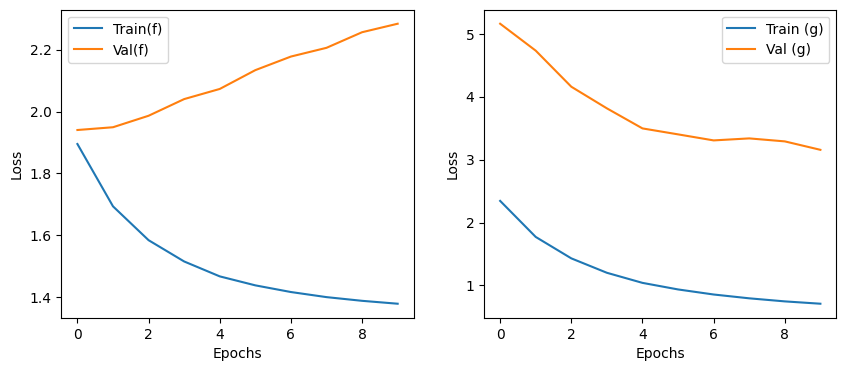

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(f_train_hist, label='Train(f)')
ax[0].plot(f_val_hist, label='Val(f)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(g_train_hist, label='Train (g)')
ax[1].plot(g_val_hist, label='Val (g)')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

### 3.2. Performance curves

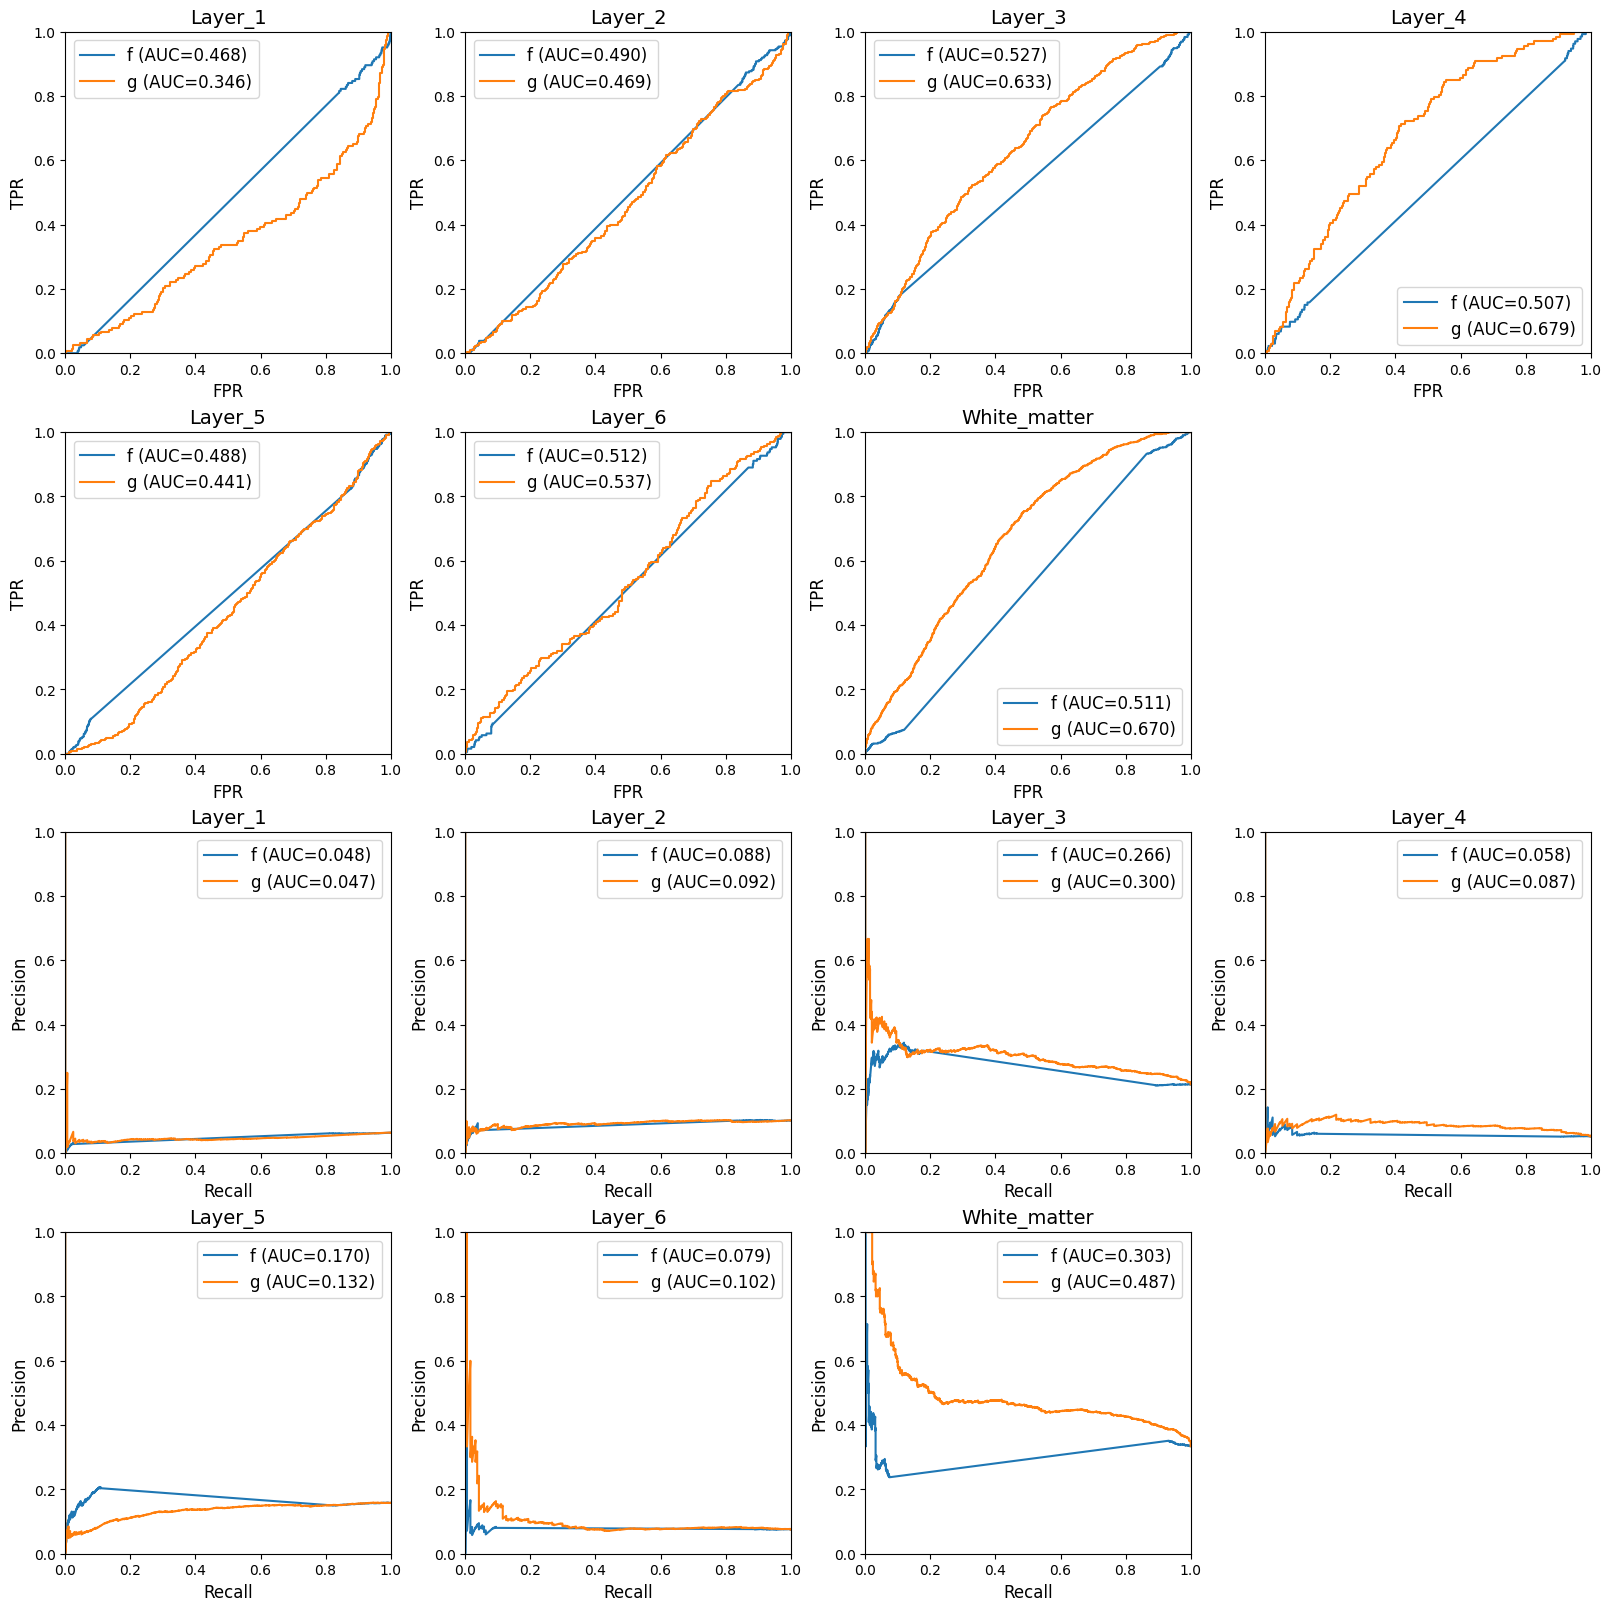

In [17]:
# Performance curves (ROC, precision-recall)
true_vals, f_preds, f_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=True)
true_vals, g_preds, g_smax = all_fgd_predictions(dataloader_grids['val'], g, f_only=False)

fig, ax, macro_auroc, macro_auprc = performance_curves(true_vals, [f_smax, g_smax], class_names, ['f', 'g'])

### 3.3. Exporting predicted annotations in Loupe format

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.to(device)
g.eval()

annot_dir = '../outputs/annot_preds'
if not os.path.exists(annot_dir):
    os.mkdir(annot_dir)

for i in range(len(val_gdat)):
    x, _ = val_gdat[i]
    x = x.to(device)
    pos_file = visium_find_position_file(val_srd[i])
    arr_name = pos_file.split('/')[-4]

    with torch.no_grad():
        y_pred = g(x).squeeze()  # remove (unit) batch dimension
        label_pred = torch.argmax(y_pred, axis=0)
        to_loupe_annots(label_pred, pos_file, os.path.join(annot_dir, arr_name+'_countpred.csv'), annot_names=class_names)